**<h2> Milestone II (Team 10) - First Standup </h2>**
<h3> Topic: Machine learning on duty: solving consumer complaints and improving satisfaction!</h3>
<h4> Group Members: </h4>

*   Weiming Chen (weimingc)
*   Yi-Hsin Chien (yihsinc)
*   Chih-Han Yeh (yehch)

<h4> Mentor: Alexis Castellanos </h4>

### **Project Overview**
In response to the escalating volume of consumer complaints and the complexities involved in addressing them promptly, our dedicated team is committed to leveraging data-driven strategies to enhance our comprehension of these complaints. Our overarching objective is to develop efficient techniques for managing and resolving complaints by predicting which ones are likely to be disputed by consumers and unveiling concealed patterns or clusters within the narrative of these complaints.

### **Dataset**
Consumer Complaint Database from CFPB (Consumer Financial Protection Bureau)

Source: https://www.consumerfinance.gov/data-research/consumer-complaints/#download-the-data

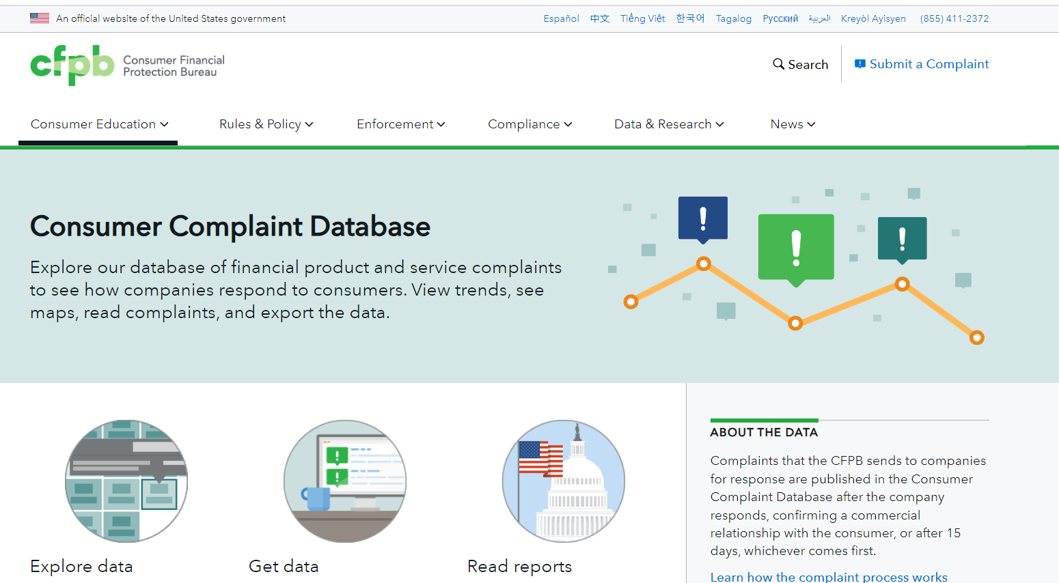

<h3>Environment Setting</h3></br>
Importing libraries we need for our project.

In [ ]:
import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from wordcloud import WordCloud
from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from textblob import TextBlob

# disable altair limit
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# files
file_path_01 = '/content/drive/My Drive/Colab Notebooks/complaints.csv'

In [ ]:
# load complaints data
data = pd.read_csv(file_path_01)
#display first 5 rows
data.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2023-08-23,"Payday loan, title loan, or personal loan",Installment loan,Problem when making payments,NaN,NaN,NaN,OneMain Finance Corporation,NC,27407,NaN,NaN,Web,2023-08-23,Closed with explanation,Yes,NaN,7448359
1,2023-08-23,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account information incorrect,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,GA,30318,NaN,Consent not provided,Web,2023-08-23,Closed with non-monetary relief,Yes,NaN,7442747
2,2023-08-23,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"Maximus Education, LLC dba Aidvantage",OH,43035,Servicemember,NaN,Web,2023-08-23,Closed with explanation,Yes,NaN,7442667
3,2023-08-23,Credit card or prepaid card,Store credit card,Fees or interest,Charged too much interest,NaN,Company has responded to the consumer and the ...,"CITIBANK, N.A.",KY,41018,Older American,NaN,Phone,2023-08-23,Closed with explanation,Yes,NaN,7442765
4,2023-08-23,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,NaN,NaN,FORD MOTOR CREDIT CO.,FL,336XX,NaN,NaN,Web,2023-08-23,In progress,Yes,NaN,7448366


<h2>Exploratory Data Analysis</h2></br>


To understand our dataset, our team performs EDA on our data.

### **Data shape: (4028530, 18)**



In [ ]:
#show the shape of the dataframe
print(data.shape)
#check the datatype
data.info()

(4028530, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4028530 entries, 0 to 4028529
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), object(17)
memo

### **Date time range: 2011-12-01 to 2023-09-05**


In [ ]:
# astype date received and date sent to company to datetime
data['Date received'] = pd.to_datetime(data['Date received'])
data['Date sent to company'] = pd.to_datetime(data['Date sent to company'])
print("Data time range: ", data['Date received'].min().date(), data['Date received'].max().date())

Data time range:  2011-12-01 2023-09-05


### **Data counts by Year is imbalanced**

In [ ]:
# Perform the value counts and sorting
value_counts = data['Date received'].dt.year.value_counts().sort_index().reset_index()
value_counts.columns = ['Year', 'Count']

# Create the Altair chart
yearly_counts = alt.Chart(value_counts).mark_bar().encode(
    x='Year:O',
    y='Count:Q'
).properties(
    title='Yearly Counts of Data received'
)

yearly_counts

alt.Chart(...)

### **The standout of Product “Credit reporting, credit repair services, or other personal consumer reports” in complaint counts worth further analysis**

In [ ]:
# Group by month and product
monthly_product_grouped = data.groupby([data['Date received'].dt.to_period('M'), 'Product']).size().reset_index(name='Count')

# Pivot the table
pivot_monthly_product = monthly_product_grouped.pivot(index='Date received', columns='Product', values='Count').fillna(0)

# Convert Period back to datetime for plotting
pivot_monthly_product.index = pivot_monthly_product.index.to_timestamp()

# Reshape the data for Altair
pivot_monthly_product.reset_index(inplace=True)
melted_data = pd.melt(pivot_monthly_product, id_vars=['Date received'], var_name='Product', value_name='Count')

# Create the Altair chart
chart = alt.Chart(melted_data).mark_line().encode(
    x=alt.X('Date received:T', title='Month'),
    y=alt.Y('Count:Q', title='Number of Complaints'),
    color=alt.Color('Product:N', title='Product'),
    tooltip=['Date received:T', 'Product:N', 'Count:Q']
).properties(
    title='Monthly Trends of Complaints Received by Product',
    width=700,
    height=400
)

chart

alt.Chart(...)

<h2>Exploratory Data Analysis & Issues</h2></br>

### **Imbalanced Data**

In [ ]:
# Get frequency of disputed complaints
disputed = data['Consumer disputed?'].value_counts()

# Calculate dispute rate
total_complaints = disputed.sum()
dispute_rate = disputed['Yes'] / total_complaints

# Create a DataFrame for Altair
disputed_df = pd.DataFrame({'Dispute': ['No', 'Yes'], 'Percentage': [100 - dispute_rate * 100, dispute_rate * 100]})
# Create an Altair stacked bar chart for the consumer dispute rate
bar_chart_dispute = alt.Chart(disputed_df).mark_bar().encode(
    x=alt.X('Percentage:Q', title='% of Complaints'),
    y=alt.Y('Dispute:N', title='Consumer Disputed'),
    color=alt.Color('Dispute:N', title='Consumer Disputed', scale=alt.Scale(range=['green', 'red'])),
    tooltip=['Dispute:N', 'Percentage:Q']
).properties(
    title='Consumer Disputed Rate',
    width=400,
    height=150
)

bar_chart_dispute

alt.Chart(...)

### **Intensive text preprocessing is needed**

Word Cloud of Consumer Complaint Narratives

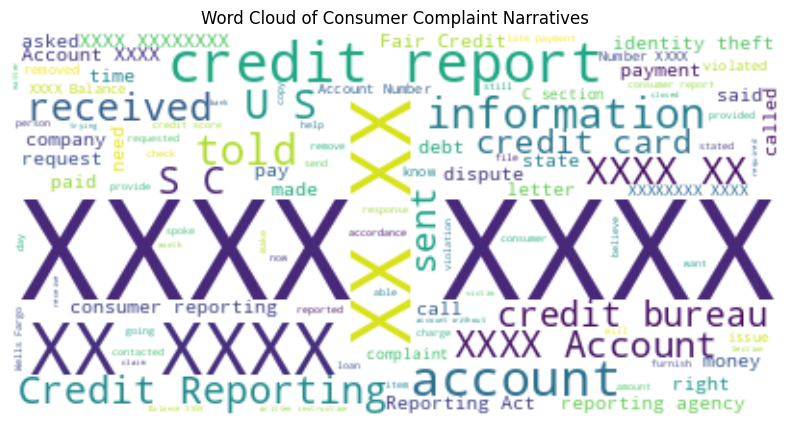

In [ ]:
consumer_complaints = data['Consumer complaint narrative'].dropna()  # Remove rows with missing narratives
text = ' '.join(consumer_complaints)  # Combine all narratives into a single text

# Create and generate a word cloud image
wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white").generate(text)

# Display the generated image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Consumer Complaint Narratives')
plt.show()

### **Missing Values**

<h4>Missing values percentage</h4></br>
Checking the percentage of missing values in a dataset is pivotal to assessing its quality and reliability. This metric guides decisions on whether to impute, drop, or retain data, especially since many algorithms necessitate datasets devoid of missing values. Moreover, unaddressed missing values can introduce bias, skewing results, and potentially misguiding subsequent analyses. Thus, recognizing and addressing data gaps ensures robust and unbiased data-driven outcomes.

In [ ]:
# check for missing values percentage
data.isnull().sum()/len(data)

Date received                   0.000000
Product                         0.000000
Sub-product                     0.058406
Issue                           0.000000
Sub-issue                       0.177570
Consumer complaint narrative    0.637554
Company public response         0.538235
Company                         0.000000
State                           0.010704
ZIP code                        0.007499
Tags                            0.895048
Consumer consent provided?      0.222613
Submitted via                   0.000000
Date sent to company            0.000000
Company response to consumer    0.000001
Timely response?                0.000000
Consumer disputed?              0.809271
Complaint ID                    0.000000
dtype: float64

**Missing values percentage by year**

In [ ]:
# add a column for year,
# missing values percentage by column and by year
data['year'] = pd.DatetimeIndex(data['Date received']).year

# transpose the table to get a better view, store it in a new dataframe
data_year = data.groupby('year').apply(lambda x: x.isnull().sum()/len(x)).T

#display results
data_year

year,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
Date received,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Product,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Sub-product,0.496845,0.238020,0.255778,0.293559,0.315560,0.348470,0.099731,0.000058,0.000047,0.000034,0.000103,0.000034,0.000000
Issue,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Sub-issue,1.000000,0.973982,0.763674,0.525397,0.534102,0.516204,0.239707,0.138887,0.124984,0.088916,0.093214,0.056405,0.038081
Consumer complaint narrative,1.000000,1.000000,1.000000,1.000000,0.675007,0.593541,0.525980,0.539551,0.549708,0.607596,0.589528,0.578688,0.688139
Company public response,1.000000,0.999972,0.999917,0.999131,0.633726,0.479627,0.519182,0.495718,0.480696,0.431368,0.598439,0.426376,0.512120
Company,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
State,0.005915,0.008498,0.009731,0.006542,0.006791,0.006932,0.016351,0.029107,0.028471,0.018199,0.011631,0.002481,0.003404
ZIP code,0.005126,0.006853,0.007670,0.003993,0.004464,0.004430,0.013049,0.025550,0.025168,0.016153,0.005028,0.000217,0.000114


- Visualizing the result

In [ ]:
#set up the plot dataframe
heat_map_df = data_year.round(2).reset_index()

#melt the wide form to long form for plotting
data_melted = heat_map_df.melt(id_vars=['index'],
                        value_vars=[2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
                        var_name='column', value_name='value')
#rename for clarity
data_melted.rename(columns={
    'index': 'column',
    'column': 'year',
    'value': 'percentage'
}, inplace=True)

#using Altair to plot the heatmap
chart = alt.Chart(data_melted).mark_rect().encode(
    x= alt.X('year:O', title= "Year"),
    y= alt.Y('column:O', title = "Column Names"),
    color= alt.Color('percentage:Q', scale = alt.Scale(scheme='yelloworangered'), legend=alt.Legend(title="Percentage of Missing Value")),
    tooltip=['column', 'year', 'percentage']
).properties(
    title = alt.TitleParams(
        text = "Heatmap: Percentage of Missing Value of each column by year",
        anchor = 'middle',
        offset = 30
    )
).configure(background='#f5faf6')

chart.display()

alt.Chart(...)

<h2>Our Next Step</h2></br>




## **Supervised learning tasks**



*   Features: 'Product' type, 'Consumer complaint narrative’…
*   Target variable: 'Consumer disputed?' label

*   Algorithms to use: Logistic Regression, XGBClassifier, Neural Networks,  etc.
*   Information retrieval techniques:  TF-IDF, CountVectorizer, Word2Vec.
*   Evaluation Metrics